In [2]:
!apt-get install git-lfs -y
!git lfs install
!git clone https://huggingface.co/datasets/Zongrong/Small_OpenEarthMap

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Git LFS initialized.
Cloning into 'Small_OpenEarthMap'...
remote: Enumerating objects: 7347, done.
remote: Counting objects: 100% (7344/7344), done.
remote: Compressing objects: 100% (7344/7344), done.
remote: Total 7347 (delta 0), reused 7344 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (7347/7347), 1.01 MiB | 8.55 MiB/s, done.
Updating files: 100% (7339/7339), done.
Filtering content: 100% (7338/7338), 959.76 MiB | 11.31 MiB/s, done.


In [3]:
!git clone https://huggingface.co/datasets/Zongrong/House_price

Cloning into 'House_price'...
remote: Enumerating objects: 29510, done.
remote: Counting objects: 100% (29507/29507), done.
remote: Compressing objects: 100% (29500/29500), done.
remote: Total 29510 (delta 20), reused 29482 (delta 5), pack-reused 3 (from 1)
Receiving objects: 100% (29510/29510), 4.77 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (29468/29468), done.
Filtering content: 100% (29460/29460), 2.67 GiB | 5.09 MiB/s, done.


In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

In [2]:
# --------------------------------
# 1. Dataset Definition: Custom Dataset
# --------------------------------
class SatelliteSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None):
        super().__init__()
        # Get the paths of images and masks
        image_paths = sorted(glob.glob(os.path.join(images_dir, "*.png")))
        mask_paths = sorted(glob.glob(os.path.join(masks_dir, "*.png")))

        # Extract file names (excluding extensions)
        image_names = {os.path.splitext(os.path.basename(p))[0] for p in image_paths}
        mask_names = {os.path.splitext(os.path.basename(p))[0] for p in mask_paths}

        # Take the intersection of image and mask file names
        common_names = sorted(image_names & mask_names)

        # Regenerate paths based on the intersection
        self.image_paths = [os.path.join(images_dir, f"{name}.png") for name in common_names]
        self.mask_paths = [os.path.join(masks_dir, f"{name}.png") for name in common_names]

        print(f"Number of matched images and masks: {len(self.image_paths)}")

        self.transform = transform
        self.target_transform = target_transform
        self.resize = transforms.Resize((768, 768))  # Ensure consistent size

        # Define the mapping from RGB to class labels
        self.rgb_to_label = {
            (128, 128, 128): 1,      # Bareland
            (0, 0, 0): 2,     # Rangeland
            (255, 255, 255): 3,  # Developed space
        }

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Read the image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Resize to 768x768
        image = self.resize(image)
        mask = self.resize(mask)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Convert the mask from RGB to class indices
        mask_np = np.array(mask)  # Convert to NumPy array, shape (H, W, 3)
        label_np = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.uint8)  # Initialize the class index array

        for rgb, cls_idx in self.rgb_to_label.items():
            # Find pixels matching the RGB value and set the class index
            match = np.all(mask_np == np.array(rgb), axis=-1)
            label_np[match] = cls_idx

        label_tensor = torch.from_numpy(label_np).long()  # Convert to PyTorch tensor

        # Apply transformations to the label
        if self.target_transform:
            label_tensor = self.target_transform(label_tensor)

        return image, label_tensor

In [5]:
# --------------------------------
# 2. Prepare Dataset and DataLoader
# --------------------------------
# Modify paths based on the directory structure after cloning the repository
root_dir = "E:/Flood_Project/DeepLabV3Plus"
images_dir = os.path.join(root_dir, "images")
masks_dir = os.path.join(root_dir, "labels")

# Basic transformations for input images (resize to 768x768)
transform = transforms.Compose([
    transforms.Resize((768, 768)),  # Resize to 768x768 to match data examples
    transforms.ToTensor(),
])

# Define the dataset
dataset = SatelliteSegDataset(images_dir, masks_dir, transform=transform)

# Split into training and validation sets
train_size = int(0.7 * len(dataset))  # Training set: Validation set = 7:3
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader configuration
batch_size = 5  # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Number of matched images and masks: 400


In [6]:
# --------------------------------
# 3. Define the DeeplabV3+ Model and Prepare for Training
# --------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the DeeplabV3 (ResNet50) version from torchvision
# pretrained=True loads a backbone pre-trained on ImageNet
model = models.segmentation.deeplabv3_resnet50(pretrained=True)

# Modify the final classification head to set the number of output channels = 1 (background) + 8 (custom-defined classes) = 9
# If not considering the background, set it to 8 channels
num_classes = 9  # Total number of classes, including the background
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

# Load the model onto the device
model = model.to(device)

# Define the optimizer and loss function
# CrossEntropyLoss is commonly used for semantic segmentation tasks
# Set ignore_index=0 to ignore the background (e.g., unannotated regions)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Use the Adam optimizer with a learning rate of 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

c:\Users\Admin\.conda\envs\floodPrj\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\.conda\envs\floodPrj\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 72.7MB/s] 


In [7]:
from tqdm import tqdm  # Import tqdm
import numpy as np

num_epochs = 10  # Maximum number of training epochs
patience = 2  # Early stopping patience
best_val_loss = np.inf  # To record the best validation loss
counter = 0  # Early stopping counter

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")  # Initialize progress bar

    for batch_idx, (images, labels) in progress_bar:
        # Load input images and labels to GPU/CPU
        images = images.to(device)  # [B, 3, H, W]
        labels = labels.to(device)  # [B, H, W]

        # Forward pass, compute loss, backward pass, and optimization
        optimizer.zero_grad()
        outputs = model(images)

        # DeeplabV3 output is a dict: {"out": seg_logits, "aux": aux_logits}
        # Usually, only "out" is used to compute loss
        logits = outputs["out"]  # [B, num_classes, H, W]

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update progress bar with batch loss information
        progress_bar.set_postfix({"Batch Loss": loss.item(), "Avg Loss": total_loss / (batch_idx + 1)})

    # Compute the average loss for the training set
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} finished. Average Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:  # DataLoader for the validation set
            # Load validation images and labels to GPU/CPU
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Forward pass
            val_outputs = model(val_images)
            val_logits = val_outputs["out"]

            # Accumulate validation loss
            val_loss += criterion(val_logits, val_labels).item()

    # Compute the average loss for the validation set
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Validation loss improved. Model saved!")
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")

    if counter >= patience:
        print(f"Early stopping triggered after {counter} epochs without improvement.")
        break

Epoch 1/10


Training: 100%|██████████| 56/56 [00:48<00:00,  1.15it/s, Batch Loss=1.21, Avg Loss=1.63] 


Epoch 1 finished. Average Training Loss: 1.6322
Epoch 1 Validation Loss: 1.1443
Validation loss improved. Model saved!
Epoch 2/10


Training: 100%|██████████| 56/56 [03:47<00:00,  4.07s/it, Batch Loss=0.854, Avg Loss=1.06]


Epoch 2 finished. Average Training Loss: 1.0568
Epoch 2 Validation Loss: 0.9233
Validation loss improved. Model saved!
Epoch 3/10


Training: 100%|██████████| 56/56 [01:40<00:00,  1.80s/it, Batch Loss=0.543, Avg Loss=0.879]


Epoch 3 finished. Average Training Loss: 0.8793
Epoch 3 Validation Loss: 0.9036
Validation loss improved. Model saved!
Epoch 4/10


Training: 100%|██████████| 56/56 [01:41<00:00,  1.80s/it, Batch Loss=0.522, Avg Loss=0.849]


Epoch 4 finished. Average Training Loss: 0.8495
Epoch 4 Validation Loss: 0.7428
Validation loss improved. Model saved!
Epoch 5/10


Training: 100%|██████████| 56/56 [01:42<00:00,  1.82s/it, Batch Loss=0.758, Avg Loss=0.708]


Epoch 5 finished. Average Training Loss: 0.7076
Epoch 5 Validation Loss: 0.6890
Validation loss improved. Model saved!
Epoch 6/10


Training: 100%|██████████| 56/56 [01:45<00:00,  1.88s/it, Batch Loss=0.339, Avg Loss=0.634]


Epoch 6 finished. Average Training Loss: 0.6340
Epoch 6 Validation Loss: 0.7597
No improvement in validation loss for 1 epoch(s).
Epoch 7/10


Training: 100%|██████████| 56/56 [01:44<00:00,  1.87s/it, Batch Loss=0.559, Avg Loss=0.61] 


Epoch 7 finished. Average Training Loss: 0.6098
Epoch 7 Validation Loss: 0.6764
Validation loss improved. Model saved!
Epoch 8/10


Training: 100%|██████████| 56/56 [01:44<00:00,  1.86s/it, Batch Loss=0.62, Avg Loss=0.522] 


Epoch 8 finished. Average Training Loss: 0.5222
Epoch 8 Validation Loss: 0.6792
No improvement in validation loss for 1 epoch(s).
Epoch 9/10


Training: 100%|██████████| 56/56 [01:44<00:00,  1.86s/it, Batch Loss=0.323, Avg Loss=0.579]


Epoch 9 finished. Average Training Loss: 0.5793
Epoch 9 Validation Loss: 0.6265
Validation loss improved. Model saved!
Epoch 10/10


Training: 100%|██████████| 56/56 [01:43<00:00,  1.84s/it, Batch Loss=0.307, Avg Loss=0.511]


Epoch 10 finished. Average Training Loss: 0.5108
Epoch 10 Validation Loss: 0.6669
No improvement in validation loss for 1 epoch(s).


Unique classes in pred: [1 2 3]


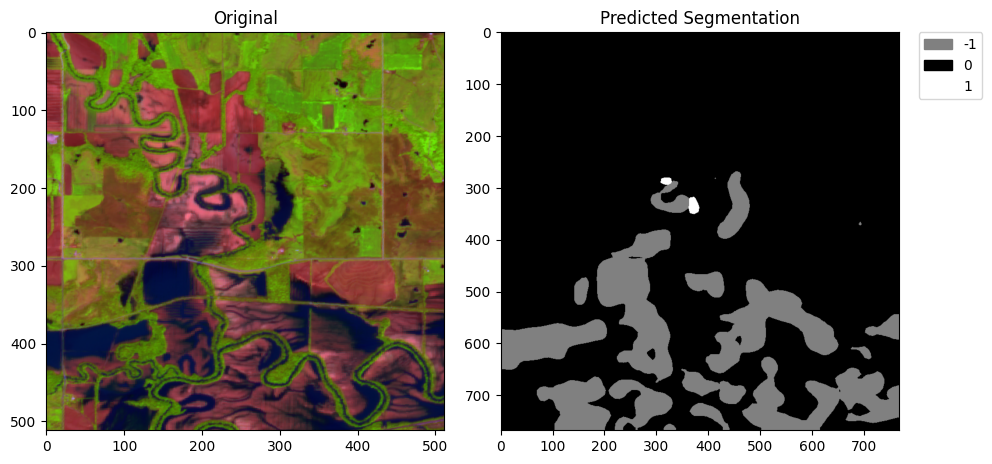

In [10]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from torchvision import transforms
# If you customized the transform during training, use the same set of transforms here
# transform = ...

# Assume you have finished training above, and the model is ready for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # Switch to evaluation mode

# ------------------------------------------------------
# 1. Inference: Load image -> Pass through model -> Get predicted mask
# ------------------------------------------------------
test_image_path = "E:/Flood_Project/DeepLabV3Plus/images/USA_955053.png"

# Load and transform the image
input_image = Image.open(test_image_path).convert("RGB")
# Ensure the transform matches what was used during training
input_tensor = transform(input_image).unsqueeze(0).to(device)  # [1, 3, H, W]

# Forward inference
with torch.no_grad():
    outputs = model(input_tensor)     # dict: {"out": logits, "aux": ...}
    logits = outputs["out"]          # [1, 7, H, W] Assuming 7 channels (including background)
    pred = logits.argmax(dim=1)      # [1, H, W]
    pred = pred.squeeze(0).cpu().numpy()  # (H, W) as a NumPy array

# ------------------------------------------------------
# 2. Map the prediction back to a color visualization
# ------------------------------------------------------
# Based on the earlier definition: 1=Bareland; 2=Rangeland; 3=Developed space; 4=Road; 5=Tree; 6=Water; 7=Agriculture land; 8=Building
idx2color = np.array(
   [[128, 128, 128],  # Background
    [0, 0, 0],  # 1=Bareland
    [255, 255, 255],  # 2=Rangeland
], dtype=np.uint8)

# Verify the range of pred values
unique_classes = np.unique(pred)
print("Unique classes in pred:", unique_classes)

# Map out-of-range classes to the background
pred[pred >= len(idx2color)] = 0

pred_color = idx2color[pred]               # Convert to (H, W, 3) colored result
pred_image = Image.fromarray(pred_color)   # Convert to PIL Image

# ------------------------------------------------------
# 3. Visualization: Left = original image, Right = predicted segmentation, with legend
# ------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: Original image
axes[0].imshow(input_image)
axes[0].set_title("Original")

# Right: Predicted segmentation
axes[1].imshow(pred_image)
axes[1].set_title("Predicted Segmentation")

# Optionally remove axis labels:
# axes[0].axis('off')
# axes[1].axis('off')

# Define 8 classes -> RGB mapping (matching idx2color)
color_mapping = {
    "-1": [128, 128, 128],
    "0": [0, 0, 0],
    "1": [255, 255, 255],
}

# Create a list of Patches for the legend
patches = []
for label_name, (r, g, b) in color_mapping.items():  # Use color_mapping instead of color_map
    # Matplotlib requires colors in the range [0, 1] as floats
    color_norm = (r / 255.0, g / 255.0, b / 255.0)
    patch = mpatches.Patch(color=color_norm, label=label_name)
    patches.append(patch)

# Set the legend on the right
plt.legend(
    handles=patches,
    bbox_to_anchor=(1.05, 1),  # x=1.05, y=1 in figure coordinates
    loc='upper left',
    borderaxespad=0.0
)

plt.tight_layout()
plt.show()

In [11]:
# Assume your model is `model`, save it to the specified path
model_save_path = "./deeplabv3_finetuned_RS_Sen1Flood11_V1.pth"

# Save only the model parameters (recommended)
torch.save(model.state_dict(), model_save_path)

print(f"Model weights saved to {model_save_path}")

Model weights saved to ./deeplabv3_finetuned_RS_Sen1Flood11_V1.pth


In [9]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from torchvision import transforms

In [10]:
# =============== 1. Preparation of Device, Model, and Transform ===============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume your model is already loaded here and ready for inference
# model = ...
model.eval()  # Switch to evaluation mode

# Note: No resizing to (512, 512) here. Instead, convert directly to tensor
# to retain the original 640x640 or other dimensions
transform = transforms.Compose([
    transforms.ToTensor(),
])

# =============== 2. Specify Input and Output Directories ===============
input_dir = "./in"     # Folder containing input images
output_dir = "./Transfer_bias/Data/RS_Masked/Austin"  # Folder to save inference results
os.makedirs(output_dir, exist_ok=True)

In [11]:
# =============== 3. Define Your Color Palette idx2color ===============
# Ensure it matches the class indices used during training
idx2color = np.array(
   [
       [0, 0, 0],       # 0: background
       [128, 0, 0],     # 1=Bareland
       [0, 255, 36],    # 2=Rangeland
       [148, 148, 148], # 3=Developed space
       [255, 255, 255], # 4=Road
       [34, 97, 38],    # 5=Tree
       [0, 69, 255],    # 6=Water
       [75, 181, 73],   # 7=Agriculture land
       [222, 31, 7]     # 8=Building
   ],
   dtype=np.uint8
)

# Optional: If you want to visualize with a legend, keep this dictionary
color_mapping = {
    "Bareland": [128, 0, 0],
    "Grass": [0, 255, 36],
    "Pavement": [148, 148, 148],
    "Road": [255, 255, 255],
    "Tree": [34, 97, 38],
    "Water": [0, 69, 255],
    "Cropland": [75, 181, 73],
    "Building": [222, 31, 7],
}

In [12]:
# =============== 4. Batch Process All Images in the Specified Folder ===============
valid_exts = {".jpg", ".png", ".jpeg"}
for file_name in os.listdir(input_dir):
    ext = os.path.splitext(file_name)[1].lower()
    if ext not in valid_exts:
        continue

    img_path = os.path.join(input_dir, file_name)
    print(f"Inferencing on: {img_path}")

    # =============== 4.1. Read and Transform ===============
    input_image = Image.open(img_path).convert("RGB")
    input_tensor = transform(input_image).unsqueeze(0).to(device)  # [1,3,H,W]

    # =============== 4.2. Forward Inference ===============
    with torch.no_grad():
        outputs = model(input_tensor)
        logits = outputs["out"]                  # [1, num_classes, H, W]
        pred = logits.argmax(dim=1)              # [1, H, W]
        pred = pred.squeeze(0).cpu().numpy()     # (H, W)

    # =============== 4.3. Map Prediction to Color Image ===============
    # Classes outside the defined range are treated as background
    pred[pred >= len(idx2color)] = 0
    pred_color = idx2color[pred]  # (H, W, 3)
    pred_image = Image.fromarray(pred_color)

    # =============== 4.4. Save the Prediction Result to output_dir ===============
    save_path = os.path.join(output_dir, file_name)
    pred_image.save(save_path)
    print(f"Saved predicted segmentation to: {save_path}")

    # If you want to visualize immediately, uncomment the following code:
    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # axes[0].imshow(input_image)
    # axes[0].set_title("Original")
    # axes[1].imshow(pred_image)
    # axes[1].set_title("Predicted Segmentation")
    #
    # patches = []
    # for label_name, (r, g, b) in color_mapping.items():
    #     color_norm = (r/255.0, g/255.0, b/255.0)
    #     patch = mpatches.Patch(color=color_norm, label=label_name)
    #     patches.append(patch)
    #
    # plt.legend(handles=patches,
    #            bbox_to_anchor=(1.05, 1),
    #            loc='upper left',
    #            borderaxespad=0.0)
    # plt.tight_layout()
    # plt.show()

Inferencing on: /content/in/satellite_37.2758_-121.861618.jpg
Saved predicted segmentation to: /content/out/satellite_37.2758_-121.861618.jpg
Inferencing on: /content/in/satellite_37.2976_-121.898335.jpg
Saved predicted segmentation to: /content/out/satellite_37.2976_-121.898335.jpg
Inferencing on: /content/in/satellite_37.2344_-121.815326.jpg
Saved predicted segmentation to: /content/out/satellite_37.2344_-121.815326.jpg
Inferencing on: /content/in/satellite_37.278_-121.73682.jpg
Saved predicted segmentation to: /content/out/satellite_37.278_-121.73682.jpg
Inferencing on: /content/in/satellite_37.2486_-121.782853.jpg
Saved predicted segmentation to: /content/out/satellite_37.2486_-121.782853.jpg
Inferencing on: /content/in/satellite_37.2805_-121.930959.jpg
Saved predicted segmentation to: /content/out/satellite_37.2805_-121.930959.jpg
Inferencing on: /content/in/satellite_37.374_-121.811407.jpg
Saved predicted segmentation to: /content/out/satellite_37.374_-121.811407.jpg
Inferencing 